In [1]:
import os
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import log_evaluation
import optuna
import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_squared_error

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
    get_masked_map
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
bahamas_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_sentinel_merged')
)
load_bahamas_eop = LoadTask(bahamas_eop_path)

data_mask_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_mask_feature,
    output_feature=train_test_mask_feature,
    bins=[0.025, 0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_mask_feature
)

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_bahamas_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task,
)
read_merge_wf = EOWorkflow(nodes)

train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 894, 1946, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 894, 1946, 12), dtype=float32)
    L2W_data: numpy.ndarray(shape=(1, 894, 1946, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(894, 1946, 1), dtype=float64)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(894, 1946, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(894, 1946, 1), dtype=int64)
    validation_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
  }
  meta_info={
    test_count: 1653194
    test_perc: 0.950262225502436
    train_count: 43427
    train_perc: 0.02496200546753393
    validation_count: 43103
    validation_perc: 0.02477576903003005
  }
  bbox=BBox(((758523.8845987623, 2793786.7214435483), (777983.8845987623, 2802726.7214435483)), c

In [3]:
train_test_eop.meta_info

{'train_count': 43427,
 'test_count': 1653194,
 'validation_count': 43103,
 'train_perc': 0.02496200546753393,
 'test_perc': 0.950262225502436,
 'validation_perc': 0.02477576903003005}

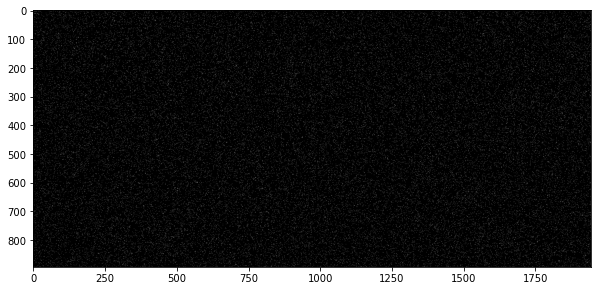

In [4]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False, stretch=False)
plt.show()

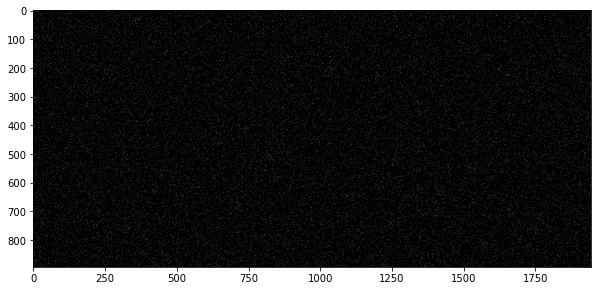

In [5]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'validation_split_valid'), colorbar=False, stretch=False)
plt.show()

In [6]:
X_train, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
train_ds = lgb.Dataset(X_train, label=y_train)
X_train.shape, y_train.shape


((43427, 12), (43427,))

In [7]:
X_val, y_val = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Validation,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
val_ds = lgb.Dataset(X_val, label=y_val)
X_val.shape, y_val.shape

((43103, 12), (43103,))

In [8]:
from IPython.utils import io

params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'boosting_type': 'dart',
    'num_boost_round': 100,
    'force_col_wise': True,
    'seed': 42,
}

with io.capture_output() as capture:
    model = lgb.train(
        params,
        train_ds,
        valid_sets=[train_ds, val_ds],
        callbacks=[log_evaluation(100)],
        optuna_seed=42,
    )

with open('../optuna_logs/optimization_stdout.txt', 'w') as f:
    f.write(capture.stdout)

with open('../optuna_logs/optimization_stderr.txt', 'w') as f:
    f.write(capture.stderr)

[I 2022-05-03 22:43:44,613] A new study created in memory with name: no-name-ecf273e7-045c-4ed8-8da0-a435fab7a933
[I 2022-05-03 22:43:45,371] Trial 0 finished with value: 0.08257116717125187 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.08257116717125187.
[I 2022-05-03 22:43:46,102] Trial 1 finished with value: 0.08934565383524558 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.08257116717125187.
[I 2022-05-03 22:43:46,852] Trial 2 finished with value: 0.08120227450056508 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.08120227450056508.
[I 2022-05-03 22:43:47,629] Trial 3 finished with value: 0.08131010852400816 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.08120227450056508.
[I 2022-05-03 22:43:48,366] Trial 4 finished with value: 0.08182183554605958 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.08120227450056508.
[I 2022-05-03 22:43:49,099

In [9]:
y_val_hat = model.predict(X_val, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val, y_val_hat))
rmse

0.2780023195973441

In [13]:
best_params = model.params
best_params

{'objective': 'regression',
 'metric': 'l2',
 'boosting_type': 'dart',
 'force_col_wise': True,
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 249,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.8994655844810855,
 'bagging_freq': 2,
 'min_child_samples': 20,
 'num_iterations': 100,
 'early_stopping_round': None}

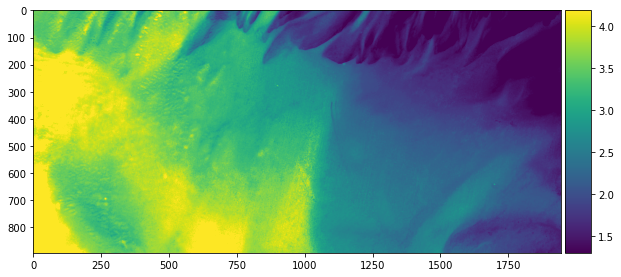

In [11]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, model, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

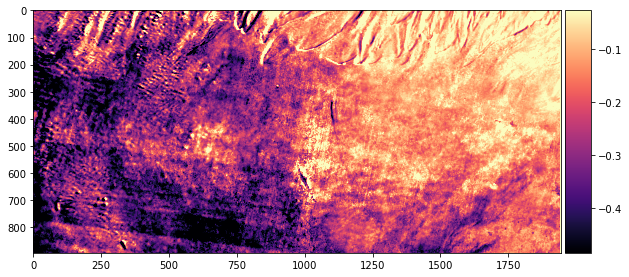

In [12]:
masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l1c_sdb_errors = l2a_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l1c_sdb_errors, cmap='magma')
plt.show()

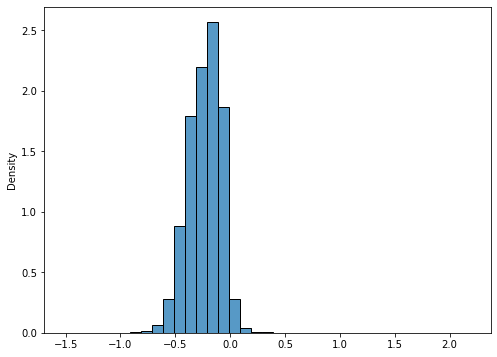

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
l1c_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l1c_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()